In [ ]:
!pip install import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import itertools

In [ ]:
import pickle

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
def mse(true, pred):
  return ((1/len(true))*np.sum((true.subtract(pred,0))**2,0)).values[0]

def mape(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0))/true,0)).values[0]

def mae(true, pred):
  return ((1/len(true))*np.sum(abs(true.subtract(pred,0)),0)).values[0]

def r2(true, pred):
  return 1-(np.sum(((pred-true.T)**2).T,0)/np.sum((true- true.mean())**2,0)).values[0]

In [ ]:
class Preprocessing:
  def __init__(self,train_link):
    self.__csv_df = pd.read_csv(train_link, parse_dates = True, index_col = 0)

    #self.__csv_df = self.__csv_df.sample(frac = 1)
    
    trainn = self.__csv_df.loc[:"2017-11-30 23:00:00"]
    test = self.__csv_df.loc["2018-01-01 00:00:00":]
    val = self.__csv_df.loc["2017-12-01 00:00:00":"2017-12-31 23:00:00"]

    self.__Y_train = pd.DataFrame(trainn.iloc[:, -1])
    self.__Y_val = pd.DataFrame(val.iloc[:, -1])
    self.__Y_test = pd.DataFrame(test.iloc[:, -1])

    self.__X_train = pd.DataFrame(trainn.iloc[:, :-1])
    self.__X_val = pd.DataFrame(val.iloc[:, :-1])
    self.__X_test = pd.DataFrame(test.iloc[:, :-1])
    
    #self.__X_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), :-1].values)
    #self.__Y_train = pd.DataFrame(self.__csv_df.iloc[:int(len(self.__csv_df)*0.75), -1].values.reshape(-1,1))
    #self.__Y_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), -1].values.reshape(-1,1))
    #self.__X_val = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.75):int(len(self.__csv_df)*0.8), :-1].values)
    #self.__X_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, :-1].values)
    #self.__Y_test = pd.DataFrame(self.__csv_df.iloc[int(len(self.__csv_df)*0.8):, -1].values.reshape(-1,1))
    
    self.__eigenvectors = []
    
    self.__pve_list = []
    self.__pca = 0
    self.__X_train_processed = 0
    self.__number_of_components = 0
    self.__scaler = 0
    self.__abs_max_scaler = []
    self.__min_max_scaler = []
    self.__means = {}
    self.__vars  = {}

  def get_Y_val(self):
    return self.__Y_val

  def get_Y_test(self):
    return self.__Y_test

  def get_Y_train(self):
    return self.__Y_train

  def get_X_val(self):
    return self.__X_val

  def standard_scale(self, dffff):
    for column in dffff.columns:
          mean_one = np.mean(np.array(dffff[column]), 0)
          final_col_train = (dffff[column] - mean_one)
          stdd = np.std(final_col_train, ddof=0)
          final_col_train =  final_col_train/stdd

          dffff[column] = final_col_train

          self.__means[column] = mean_one
          self.__vars[column] = stdd
    return dffff

  def standard_scale_test(self,df):
    for column in df.columns:
          final_col_test = ( df[column].values - self.__means[column])/self.__vars[column] 
          df[column] = final_col_test
      
    return df


  def min_max_scaling(self,dataframe):
    self.__min_max_scaler = []
    for column in dataframe.columns:
      self.__min_max_scaler.append((dataframe[column].min(),dataframe[column].max()))
      dataframe[column] = (dataframe[column] - dataframe[column].min())/(dataframe[column].max() - dataframe[column].min())
    return dataframe

  def min_max_scaling_test(self,dataframe):
    for column in dataframe.columns:
      

      column_n = dataframe.columns.get_loc(column)
      print( self.__min_max_scaler[column_n][0],self.__min_max_scaler[column_n][1])
      print( dataframe[column])
      dataframe[column] = (dataframe[column] - self.__min_max_scaler[column_n][0])/(self.__min_max_scaler[column_n][1] - self.__min_max_scaler[column_n][0])
    return dataframe

  def abs_max_scaling(self,dataframe):
    for column in dataframe.columns:
      self.__abs_max_scaler.append(dataframe[column].abs().max())
      dataframe[column] = dataframe[column]  / dataframe[column].abs().max()
    return dataframe

  def preprocess_y_shape(self):
    self.__Y_test = self.min_max_scaling(self.__Y_test)
    self.__y_train = self.min_max_scaling(self.__Y_train)
    return self.__Y_test, self.__y_train

  def get_X_values(self):
    return self.__X_train, self.__X_test 
  
  def get_min_max_scaler(self):
    return self.__min_max_scaler

  def get_PCA_plot(self, threshold):
    df = self.__pve_list
    self.__number_of_components = [x+1 for x in range(len(df))]
    return self.__number_of_components, self.__pve_list

  def get_PVE(self):
    for i in range(len(self.__pve_list)):
      print(f"Number of components:{self.__number_of_components[i]} -> PVE:{self.__pve_list[i]}")
    
  def preprocess_train(self, X_train, threshold):
    X_train = self.min_max_scaling(self.__X_train)
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_train = df_PCA
    return df_PCA
  
  def preprocess_test(self,X_test,X_train):
    X_test = self.min_max_scaling_test(self.__X_test)
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_test = df_PCA
    return df_PCA
  def preprocess_val(self,X_val,X_train):
    X_val = self.min_max_scaling_test(self.__X_val)
    df_meaned = X_val - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_val = df_PCA
    return df_PCA
  def preprocess_train_ss(self, X_train, threshold):
    X_train = self.standard_scale(X_train)
    df_meaned = (X_train - np.mean(X_train, axis = 0))
    cov_matrix = np.cov(df_meaned, rowvar = False)
    values, vectors = np.linalg.eigh(cov_matrix)

    sorted_index = np.argsort(values)[::-1]
    sorted_eigenvalue = values[sorted_index]
    sorted_eigenvectors = vectors[:,sorted_index]

    pve = []
    for i in range(len(sorted_eigenvalue)):
        pve_percen = sum(sorted_eigenvalue[:i+1])*100 / np.sum(sorted_eigenvalue)
        pve.append(pve_percen)
    
    self.__pve_list = pve
    threshold_list = [pve.index(i) for i in pve if i >= threshold]
    threshold_out = threshold_list[0]

    sorted_index = sorted_index[:threshold_out+1]
    sorted_eigenvalue = sorted_eigenvalue[:threshold_out+1]
    sorted_eigenvectors = sorted_eigenvectors[:,:threshold_out+1]
    self.__eigenvectors = sorted_eigenvectors

    df_PCA = np.dot(sorted_eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_train = df_PCA
    return df_PCA
  
  def preprocess_test_ss(self,X_test,X_train):
    X_test = self.standard_scale_test(self.__X_test)
    df_meaned = X_test - np.mean(X_train, axis = 0)
    df_PCA = np.dot(self.__eigenvectors.transpose(),df_meaned.transpose()).transpose()
    df_PCA = pd.DataFrame(data=df_PCA,columns=[f"principal_componenet {y+1}" for y in range(df_PCA.shape[1])])  
    self.__X_test = df_PCA
    return df_PCA

In [ ]:
dataframe = Preprocessing("/content/drive/MyDrive/EEE 485 Project/Code/Features_label_raw.csv")

In [ ]:
X_train,X_test = dataframe.get_X_values()
X_train_o = X_train
X_train = dataframe.preprocess_train(X_train,95)
X_train

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,1.302871,-0.495933,0.685117,0.518588,0.082945,-0.014194,0.588497,0.213073,-0.541380,-0.040026,-0.278103,-0.485133,0.059225,-0.073005,-0.085187
1,1.309744,-0.515187,0.700973,0.592722,-0.057264,-0.050078,0.635290,0.209962,-0.549906,-0.002292,-0.359998,-0.460813,0.045472,-0.037867,0.019006
2,1.307893,-0.515359,0.702773,0.603945,-0.182740,-0.082200,0.674213,0.203372,-0.554986,0.022060,-0.391507,-0.465843,0.019444,-0.050448,-0.005585
3,1.299136,-0.500933,0.701086,0.556296,-0.278612,-0.103937,0.700082,0.196794,-0.554964,0.031435,-0.403589,-0.476217,-0.009056,-0.058056,-0.028751
4,1.269049,-0.475439,0.696790,0.470626,-0.341663,-0.104242,0.700099,0.198294,-0.559738,0.060425,-0.472964,-0.428786,-0.006631,-0.007204,0.114347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,0.937617,0.467415,-0.918680,-0.585253,0.744822,0.235180,0.278800,0.011800,-0.473979,-0.126599,0.233614,-0.173844,0.009278,-0.056657,0.121034
25453,0.944814,0.460187,-0.930267,-0.590123,0.832551,0.244943,0.270717,0.009558,-0.469364,-0.190271,0.304878,-0.141336,0.030901,-0.093012,0.037517
25454,0.943603,0.436905,-0.912001,-0.534489,0.878640,0.256060,0.263723,0.019396,-0.483114,-0.206153,0.229601,-0.048282,0.142674,-0.019229,0.272851
25455,0.972135,0.398071,-0.884895,-0.394345,0.870430,0.236587,0.293666,0.016782,-0.494090,-0.236239,0.232798,-0.022408,0.184568,-0.022129,0.294897


In [ ]:
X_train.to_csv("/content/drive/MyDrive/EEE 485 Project/Code/PCA_mın_max.csv")

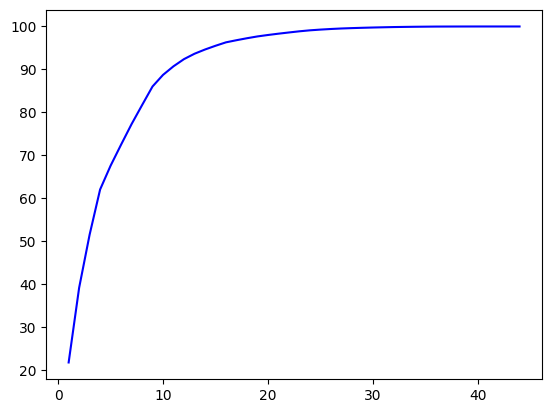

In [ ]:
(x_axis,y_axis) = dataframe.get_PCA_plot(100)
plt.plot(x_axis,y_axis,"b")

In [ ]:
X_test = dataframe.preprocess_test(X_test, X_train_o)
X_test

1359.7093125 1545.4700000000005
2018-01-01 00:00:00    1422.29
2018-01-01 01:00:00    1418.14
2018-01-01 02:00:00    1415.85
2018-01-01 03:00:00    1412.16
2018-01-01 04:00:00    1409.94
                        ...   
2018-12-31 19:00:00    1422.35
2018-12-31 20:00:00    1411.47
2018-12-31 21:00:00    1404.25
2018-12-31 22:00:00    1398.59
2018-12-31 23:00:00    1393.99
Name: temp, Length: 8756, dtype: float64
1352.75 1540.75
2018-01-01 00:00:00    1415.75
2018-01-01 01:00:00    1413.75
2018-01-01 02:00:00    1408.75
2018-01-01 03:00:00    1404.75
2018-01-01 04:00:00    1403.75
                        ...   
2018-12-31 19:00:00    1416.75
2018-12-31 20:00:00    1404.75
2018-12-31 21:00:00    1401.75
2018-12-31 22:00:00    1393.75
2018-12-31 23:00:00    1387.75
Name: temp_min, Length: 8756, dtype: float64
1359.7093125 1567.7400000000002
2018-01-01 00:00:00    1430.75
2018-01-01 01:00:00    1423.75
2018-01-01 02:00:00    1422.75
2018-01-01 03:00:00    1419.75
2018-01-01 04:00:00    1416.

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,0.905375,-0.338786,-1.114445,0.590819,0.102919,0.106314,-0.663717,0.178964,-0.566710,0.095357,-0.611649,0.120034,0.321502,-0.088544,0.244745
1,0.914154,-0.354194,-1.104246,0.722568,0.009966,0.062078,-0.609061,0.175058,-0.565348,0.097795,-0.591383,-0.001199,0.348827,-0.110551,0.153674
2,0.938330,-0.368005,-1.099667,0.844191,-0.093578,0.006572,-0.530479,0.158628,-0.558699,0.054835,-0.501439,-0.097370,0.306235,-0.141045,0.018249
3,0.970441,-0.392735,-1.079100,0.972731,-0.217000,-0.047379,-0.447537,0.141804,-0.546708,0.024121,-0.456399,-0.146452,0.202433,-0.084582,0.069038
4,0.974019,-0.413587,-1.058642,1.045566,-0.352577,-0.084639,-0.399378,0.134414,-0.551283,0.053181,-0.522419,-0.110228,0.188150,-0.050642,0.144802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,0.921221,-0.002203,-1.260984,0.014115,0.154971,0.097536,-0.616267,0.042568,-0.435353,-0.092712,-0.020792,-0.450658,-0.178836,-0.033775,-0.096954
8752,0.940821,-0.020134,-1.273776,-0.017981,0.261385,0.111602,-0.625361,0.046298,-0.431225,-0.176513,0.019898,-0.431956,-0.083190,-0.016851,-0.022965
8753,0.972651,-0.059168,-1.257667,0.074940,0.306755,0.111405,-0.613911,0.050841,-0.431960,-0.219211,-0.005444,-0.380743,-0.028058,0.044973,0.161939
8754,0.996949,-0.099713,-1.232641,0.233913,0.281293,0.091970,-0.587537,0.053246,-0.437316,-0.215406,-0.033933,-0.382377,0.008075,0.055178,0.196454


In [ ]:
X_val  = dataframe.get_X_val()

X_val = dataframe.preprocess_val(X_val, X_train_o)
X_val

1359.7093125 1545.4700000000005
2017-12-01 00:00:00    1388.09
2017-12-01 01:00:00    1381.87
2017-12-01 02:00:00    1382.70
2017-12-01 03:00:00    1380.71
2017-12-01 04:00:00    1381.20
                        ...   
2017-12-31 19:00:00    1431.82
2017-12-31 20:00:00    1430.89
2017-12-31 21:00:00    1429.73
2017-12-31 22:00:00    1428.11
2017-12-31 23:00:00    1424.73
Name: temp, Length: 744, dtype: float64
1352.75 1540.75
2017-12-01 00:00:00    1382.75
2017-12-01 01:00:00    1376.75
2017-12-01 02:00:00    1377.75
2017-12-01 03:00:00    1376.75
2017-12-01 04:00:00    1375.75
                        ...   
2017-12-31 19:00:00    1427.75
2017-12-31 20:00:00    1423.75
2017-12-31 21:00:00    1423.75
2017-12-31 22:00:00    1422.75
2017-12-31 23:00:00    1417.75
Name: temp_min, Length: 744, dtype: float64
1359.7093125 1567.7400000000002
2017-12-01 00:00:00    1394.75
2017-12-01 01:00:00    1387.75
2017-12-01 02:00:00    1388.75
2017-12-01 03:00:00    1385.75
2017-12-01 04:00:00    1387.75

,principal_componenet 1,principal_componenet 2,principal_componenet 3,principal_componenet 4,principal_componenet 5,principal_componenet 6,principal_componenet 7,principal_componenet 8,principal_componenet 9,principal_componenet 10,principal_componenet 11,principal_componenet 12,principal_componenet 13,principal_componenet 14,principal_componenet 15
0,1.070638,0.183927,-0.825489,0.028968,0.475535,0.629698,0.154421,0.157653,-0.450796,-0.305279,0.204171,-0.163422,0.034800,-0.014815,0.295173
1,1.119856,0.117123,-0.790256,0.308516,0.342365,0.578085,0.221490,0.145897,-0.463615,-0.264684,0.188846,-0.155911,-0.032318,-0.070943,0.176008
2,1.119002,0.095315,-0.758711,0.483830,0.195309,0.532402,0.271660,0.141914,-0.473217,-0.195563,0.138656,-0.204487,-0.048254,-0.099394,0.072925
3,1.148112,0.060108,-0.737591,0.651000,0.055405,0.480112,0.342559,0.128403,-0.478858,-0.189538,0.132006,-0.200317,-0.087343,-0.118705,0.035527
4,1.146542,0.052965,-0.728494,0.708711,-0.075228,0.438489,0.395187,0.118206,-0.485190,-0.177423,0.110286,-0.200631,-0.087506,-0.130779,0.003581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.959433,-0.090147,-0.745513,0.071052,0.125351,0.153215,-0.720598,0.039440,-0.565609,0.116421,-0.428338,0.460719,-0.062047,-0.260154,0.005866
740,0.952156,-0.076844,-0.763216,0.037213,0.222696,0.165199,-0.730154,0.050658,-0.562552,0.052379,-0.388203,0.387793,0.071152,-0.226239,0.083525
741,0.948570,-0.080406,-0.762802,0.116893,0.262244,0.160754,-0.726005,0.069990,-0.571703,0.038885,-0.419611,0.236854,0.296483,-0.208559,0.185962
742,0.962394,-0.109785,-0.746138,0.268403,0.237904,0.139540,-0.697939,0.069344,-0.578351,0.037660,-0.413125,0.226684,0.324283,-0.226548,0.147106


In [ ]:
X_test.to_csv("/content/drive/MyDrive/EEE 485 Project/Code/PCA_minmax_test.csv")

In [ ]:
Y_train = dataframe.get_Y_train()
Y_test = dataframe.get_Y_test()
Y_val = dataframe.get_Y_val()
Y_val = dataframe.min_max_scaling(Y_val)
Y_train = dataframe.min_max_scaling(Y_train)
Y_test = dataframe.min_max_scaling_test(Y_test)
dataframe.get_min_max_scaler()

0.0 41015.0
2018-01-01 00:00:00    22779.0
2018-01-01 01:00:00    22009.0
2018-01-01 02:00:00    20589.0
2018-01-01 03:00:00    19547.0
2018-01-01 04:00:00    18871.0
                        ...   
2018-12-31 19:00:00    30653.0
2018-12-31 20:00:00    29735.0
2018-12-31 21:00:00    28071.0
2018-12-31 22:00:00    25801.0
2018-12-31 23:00:00    24455.0
Name: total load actual, Length: 8756, dtype: float64


[(0.0, 41015.0)]

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/metrics.ipynb
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/helpers.ipynb 
!cp /content/drive/MyDrive/EEE\ 485\ Project/Code/Sunum\ kodu/Decision_Tree_regressor.ipynb

cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/metrics.ipynb'
Try 'cp --help' for more information.
cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/helpers.ipynb'
Try 'cp --help' for more information.
cp: missing destination file operand after '/content/drive/MyDrive/EEE 485 Project/Code/Sunum kodu/Decision_Tree_regressor.ipynb'
Try 'cp --help' for more information.


In [ ]:
from sklearn.tree import DecisionTreeRegressor as DT

In [ ]:
def weighted_median(values, weights):
    
    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
    return values[median_weight]

In [ ]:

class AdaBoostR2():
    def __init__(self, X_train, T = 100, stub_depth = 1, lr = 1, random_state = 42):
        #self.Y_val = Y_val
        #self.Y_test = Y_test
        #self.y_train = y_train
        self.X_train = X_train
        #self.X_test = X_test
        #self.X_val = X_val
        self.T = T
        self.lr = lr
        self.stub_depth = stub_depth
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        #np.random.seed(random_state)
        self.best_model = {"T":self.T,
                           "max_depth":self.stub_depth,
                           "lr":lr}
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        self.model_weights = np.array([])

    def fit(self, X_train, Y_train):
        self.T = self.best_model["T"]
        self.stub_depth = self.best_model["max_depth"]
        self.lr = self.best_model["lr"]
        for t in range(self.T):
            ## Draw sample, fit tree, get predictions
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights.reshape(-1))
            bootstrap_X = X_train[bootstrap_indices]
            bootstrap_y = Y_train[bootstrap_indices]
            tree = DT(max_depth = self.stub_depth)
            tree.fit(bootstrap_X, bootstrap_y)
            #print("ok")

            self.trees.append(tree)
            yhat = np.array(tree.predict(X_train))
            #return(yhat)
            self.fitted_values[:,t] = yhat
            ## Calculate observation errors
            abs_errors_t = np.abs(Y_train - yhat.reshape(-1,1))
            D_t = np.max(abs_errors_t)

            L_ts = abs_errors_t/D_t
            ## Calculate model error (and possibly break)
            
            Lbar_t = np.sum(self.weights.reshape(-1,1)*L_ts)

            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            ## Calculate and record beta 
            beta_t = self.lr * Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            ## Reweight
            Z_t = np.sum(self.weights.reshape(-1,1)  * beta_t**(1-L_ts))
            self.weights  = self.weights.reshape(-1,1) * beta_t**(1-L_ts)/Z_t
            
        ## Get median 
        self.model_weights = np.log(1/np.array(self.betas))
        #print("fit",self.model_weights )
        self.y_train_hat = np.array([weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])

        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X_test)
        #print("pred", self.model_weights)
        return np.array([weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)])

    
    def search(self, parameters, X_train, Y_train, X_val, Y_val, refit =  None):
      """
      takes 1 hour with 15 paramaters.
      parameter search for n_estimators,max_depth
      """
      param_values = [v for v in parameters.values()] 
      error_of_choice= []
      whole_turns = []
      for n_estimators, max_depth,lr in itertools.product(*param_values):
          model = AdaBoostR2(X_train, n_estimators, max_depth, lr)
          model.fit(X_train,Y_train)
          y_pred_val = model.predict(X_val)
          MSE = mse(pd.DataFrame(Y_val),y_pred_val)
          error_of_choice.append(MSE)
          whole_turns.append([n_estimators,max_depth,lr]) 
          print('n_estimators: %.4f, max_depth: %.4f, learning rate: %.4f, MSE:%.7f' % (n_estimators,max_depth,lr,MSE))
      min_error_index =error_of_choice.index(min(error_of_choice))
      choice = whole_turns[min_error_index]
      print('Best parametres','n_estimators:',choice[0],'max_depth:',choice[1],'learning rate:',choice[2], 'MSE:',min(error_of_choice))
      self.best_model = {"T":choice[0],
                           "max_depth":choice[1],
                          "lr":choice[2]} 
      if refit:
        #print("ok")
        model = AdaBoostR2(X_train, choice[0], choice[1], choice[2])

        model.fit(X_train,Y_train)
        #print("refit",self.model_weights)
      return choice

    def plot_best(self,yhat, y):
      
      plt.plot( y.index, y)
      plt.plot( y.index, yhat)
      plt.legend(["Ground Truth",  "Prediction"])
      plt.title("The Plot of Predictions and Ground Truth versus Date")
      plt.xlabel("Date")
      plt.ylabel("Energy Demand (kWh)")
      plt.show()
      return None

    def evaluation(self,X_test,X_train,  Y_test, Y_train):
       
       model = AdaBoostR2(X_train, self.best_model["T"], self.best_model["max_depth"], self.best_model["lr"])
       model.fit(np.array(X_train),np.array(Y_train))
       y_pred = model.predict(X_test)
       y_pred_train = model.predict(X_train)
       print("MSE", mse(Y_test, y_pred),"MAE", mae(Y_test, y_pred),"R2 score", r2(Y_test, y_pred))
       print("Train MSE", mse(Y_train, y_pred_train),"MAE", mae(Y_train, y_pred_train),"R2 score", r2(Y_train, y_pred_train))
       return y_pred_train, y_pred

In [ ]:
#X_train = X_train.drop(columns = ["Unnamed: 0"])


In [ ]:
#X_test = X_test.drop(columns = ["Unnamed: 0"])

In [ ]:
#Y_train = pd.DataFrame(Y_train, index = X_train.index)

n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.1000, MSE:0.0769763
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.5000, MSE:0.0722947
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 0.7500, MSE:0.0739735
n_estimators: 10.0000, max_depth: 5.0000, learning rate: 1.0000, MSE:0.0729834
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.1000, MSE:0.0722560
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.5000, MSE:0.0681706
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 0.7500, MSE:0.0653726
n_estimators: 10.0000, max_depth: 7.0000, learning rate: 1.0000, MSE:0.0661353
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.1000, MSE:0.0643000
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.5000, MSE:0.0614958
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 0.7500, MSE:0.0618327
n_estimators: 10.0000, max_depth: 9.0000, learning rate: 1.0000, MSE:0.0604986
n_estimators: 10.0000, max_depth: 11.0000, learning 

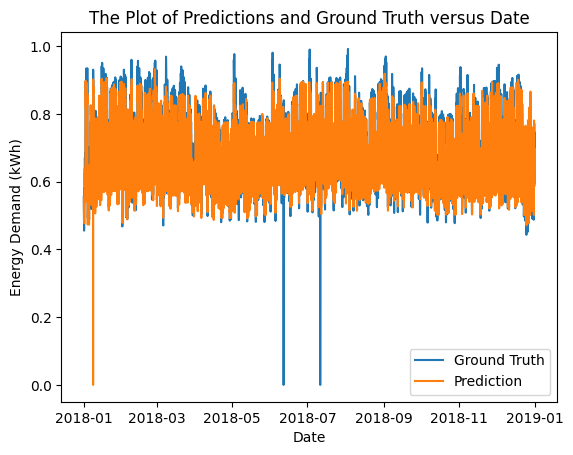

MSE 0.0016345333965927823 MAE 0.028783262945146777 R2 score 0.8726523496059879
Train MSE 0.0005342439608388371 MAE 0.017644023168878354 R2 score 0.9574661676910642


In [ ]:
param = {"n_estimators": [10,20,40],
              "max_depth":[5,7,9,11],
              "learning rate": [0.1,0.5,0.75,1],
}
model = AdaBoostR2(X_train, 15,5,1)
best_params = model.search(param,  np.array(X_train), np.array(Y_train), np.array(X_val), np.array(Y_val), refit = False)

model = AdaBoostR2(X_train,best_params[0],best_params[1], best_params[2] )
model.fit(np.array(X_train),np.array(Y_train))
y_pred_test = model.predict(X_test)
model.plot_best(y_pred_test, Y_test)
y_pred_train, y_pred = model.evaluation(X_test, X_train, Y_test, Y_train)



In [ ]:
model = AdaBoostR2(X_train, best_params[0],best_params[1], best_params[2] )
#print(self.best_model)
model.fit(np.array(X_train),np.array(Y_train))
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("MSE", mse(Y_test, y_pred),"MAE", mae(Y_test, y_pred),"R2 score", r2(Y_test, y_pred))
print("Train MSE", mse(Y_train, y_pred_train),"MAE", mae(Y_train, y_pred_train),"R2 score", r2(Y_train, y_pred_train))

MSE 0.0015106342317554844 MAE 0.028312566492214503 R2 score 0.8823054209722264
Train MSE 0.00047916917734045145 MAE 0.016607575797676206 R2 score 0.961850946514007


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = AdaBoostRegressor(estimator = DT(max_depth =11), n_estimators = 40,learning_rate=0.75)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
pred_t = model.predict(X_train)

print(mean_squared_error(Y_test,pd.DataFrame(pred)))
print(r2_score(Y_test,pd.DataFrame(pred)))
print(mean_absolute_error(Y_test,pd.DataFrame(pred)))
print(mean_squared_error(Y_train,pd.DataFrame(pred_t)))
print(r2_score(Y_train,pd.DataFrame(pred_t)))
print(mean_absolute_error(Y_train,pd.DataFrame(pred_t)))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0012686115307410611
0.9011615804000156
0.02554309862714465
0.0002994958189835986
0.9761556407266181
0.013625698346785016


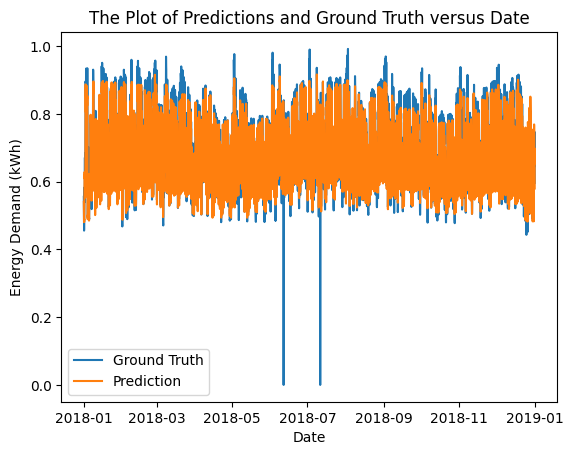

In [ ]:
MODEL = AdaBoostR2(X_train)
MODEL.plot_best(pred,Y_test)